In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md

from itertools import cycle

import pds4_tools as pds
from datetime import datetime, timedelta

str2date = lambda x: datetime.strptime(x, '00133M%H:%M:%S.%f')
str2dates = lambda xs: [str2date(xs[i]) for i in range(len(xs))]

# print(str2date('00133M00:00:28.824').microsecond)
print(str2dates(['00133M00:00:28.824', '00133M00:00:29.311', '00133M00:00:29.797']))

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

ModuleNotFoundError: No module named 'pds4_tools'

In [147]:
def calculate_scaled_windspeed(windspeeds_to_scale, z, zstar, z0=1.5):
    """
    Returns wind speed time series scaled as if it were measured at a different elevation,
    assuming a logarithmic wind profile
    
    Args:
        windspeeds_to_scale (float array): wind speeds to scale
        z (float): altitude at which measurement is assumed to take place
        zstar (float): the roughness scale - https://en.wikipedia.org/wiki/Roughness_length
        z0 (float, optional): altitude at which actual wind speed measurement was made; defaults to 1.5 meters
        kappa (float, optional): von Karman parameter; defaults to 0.4
    
    Returns:
        Scaled wind speed time series
    
    """
    
    # Calculate ustar assuming average windspeeds_to_scale
    return windspeeds_to_scale*np.log(z/zstar)/np.log(z0/zstar)

def retrieve_relevant_times(time, t0, sample_time):
    return (t0 <= time) & (time <= t0 + sample_time)

def sample_wind_profile(sample_time, t0, time, windspeeds, heights):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        times (float array): measured times
        windspeeds (dict of float arrays): wind speed time-series referenced by anemometer height
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_windspeeds = np.array([])
    std_windspeeds = np.array([])
    for i in range(len(heights)):
        ind = retrieve_relevant_times(time, t0, sample_time) 
        
        print(heights[i], np.mean(windspeeds[str(heights[i])][ind]))
        
        averaged_windspeeds = np.append(np.mean(windspeeds[str(heights[i])][ind]), averaged_windspeeds)
        std_windspeeds = np.append(np.std(windspeeds[str(heights[i])][ind])/\
                                   (np.sqrt(len(windspeeds[str(heights[i])][ind])) - 1.), std_windspeeds)
        
        cur_t0 += sample_time
        
    return averaged_windspeeds, std_windspeeds

In [2]:
struct_list = pds.read('Mars 2020 Data/WE__0133___________DER_WS__________________P01.xml')
print(struct_list)

Processing label: Mars 2020 Data/WE__0133___________DER_WS__________________P01.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
<StructureList at 0x7f8298932250> with:
<HeaderStructure 'HEADER' at 0x7f82d91de190>
<TableStructure 'TABLE' at 0x7f82985b2910>


1.5 5.110322580645162
3.0 5.930754645627666
6.0 6.751186710610172
12.0 7.571618775592677
<class 'numpy.ndarray'>
1.5 7.571618775592677
3.0 6.751186710610172
6.0 5.930754645627666
12.0 5.110322580645162


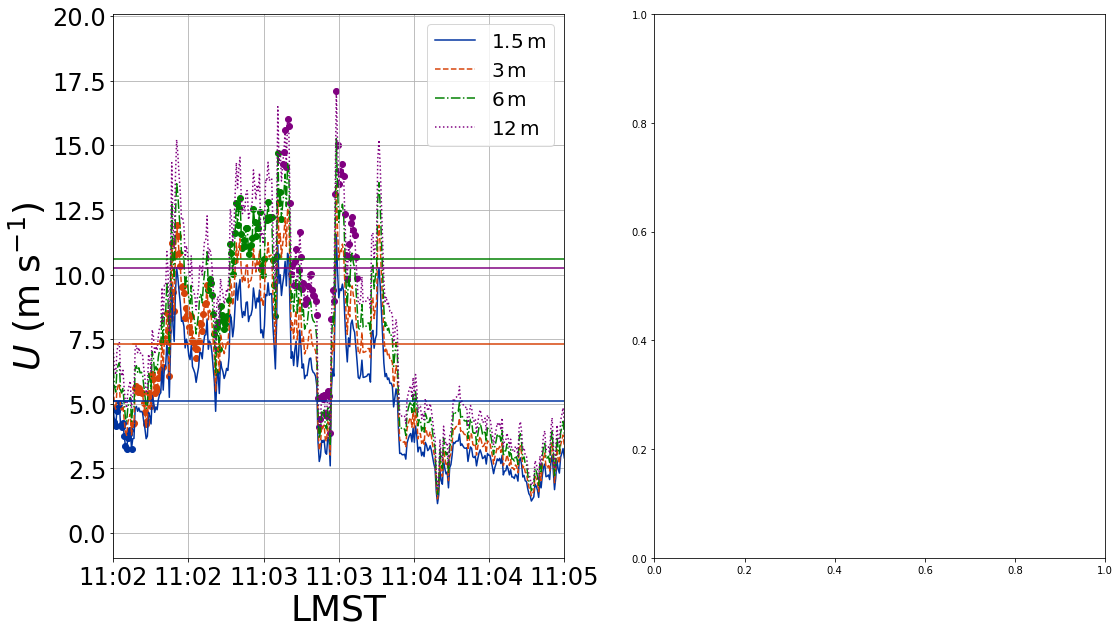

In [149]:
# struct_list.info()
# print(len(struct_list['TABLE']['HORIZONTAL_WIND_SPEED']))

colors = cycle([BoiseState_blue, BoiseState_orange, "green", "purple"])
linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])

time = np.array(str2dates(struct_list['TABLE']['LMST']))
ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
        (times > datetime(1900, 1, 1, 11, 0, 0)) & (times < datetime(1900, 1, 1, 12, 0, 0))

time = time[ind]

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# ax.scatter(times[ind], struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind], color=BoiseState_blue, marker='.')

zs = np.array([1.5, 3., 6., 12.]) # m
zstar = 2e-2 # 2 cm

scaled_windspeeds = {}
for i in range(len(zs)):
    color = next(colors)
    ls = next(linestyles)
    
    scaled_windspeeds[str(zs[i])] =\
        calculate_scaled_windspeed(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind], zs[i], zstar)

    ax1.plot(time, scaled_windspeeds[str(zs[i])], color=color, ls=ls, label=r'$%g\, {\rm m}$' % zs[i])

xfmt = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel("LMST", fontsize=36)
ax1.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax1.legend(loc='upper right', fontsize=20)
ax1.set_xlim([datetime(1900, 1, 1, 11, 2, 0), datetime(1900, 1, 1, 11, 5, 0)])

### Synthetic wind profile ###

t0 = np.min(time)
cur_t0 = t0
sample_time = timedelta(seconds=30.)
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.scatter(time[ind], scaled_windspeeds[str(zs[0])][ind], color=cur_color)
ax1.plot(time[ind], np.mean(scaled_windspeeds[str(zs[0])][ind])*np.ones_like(time[ind]), color=cur_color)
ax1.axhline(np.mean(scaled_windspeeds[str(zs[0])][ind]), color=cur_color)

cur_t0 += sample_time
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.scatter(time[ind], scaled_windspeeds[str(zs[1])][ind], color=cur_color)
ax1.plot(time[ind], np.mean(scaled_windspeeds[str(zs[1])][ind])*np.ones_like(time[ind]), color=cur_color)
ax1.axhline(np.mean(scaled_windspeeds[str(zs[1])][ind]), color=cur_color)

cur_t0 += sample_time
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.scatter(time[ind], scaled_windspeeds[str(zs[2])][ind], color=cur_color)
ax1.axhline(np.mean(scaled_windspeeds[str(zs[2])][ind]), color=cur_color)

cur_t0 += sample_time
ind = retrieve_relevant_times(time, cur_t0, sample_time)
cur_color = next(colors)
ax1.scatter(time[ind], scaled_windspeeds[str(zs[3])][ind], color=cur_color)
ax1.axhline(np.mean(scaled_windspeeds[str(zs[3])][ind]), color=cur_color)

averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)

# ax2.errorbar(averaged_windspeeds, zs)
for i in range(len(zs)):
    print(zs[i], averaged_windspeeds[i])